The notebook contains the image classification using ResNet50 model architecture

## Mounting the google drive and unzipping the dataset file in case using Colab

-You can mount your Google Drive files by running the following code snippet:

            from google.colab import drive
            drive.mount('/content/drive')


## Unziping the dataset

In [1]:
# !apt-get install unrar

In [2]:
# !unrar x /content/drive/MyDrive/Resnet/animals.rar /content/

## Check the Number of Gpus available

In [3]:
import tensorflow

In [4]:
import tensorflow as tf

print("Num Gpus Available",len(tf.config.experimental.list_physical_devices('GPU')))

Num Gpus Available 1


## Importing neccesarry libraries

In [5]:
from tensorflow.keras.layers import Input,Lambda,Dense,Flatten,Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
from imutils import paths
import cv2
import os

## PreProcessing the images
- resizing it to the desired imagesize like in this case we have set image size to (128,128)
- converting the image to array

In [6]:
IMAGE_SIZE=(128,128)

In [7]:
imagePaths="/content/animals/"
imagePaths=list(paths.list_images(imagePaths))

In [8]:
data=[]
labels=[]
for (i,imagePath) in enumerate(imagePaths):
  image=cv2.imread(imagePath)
  image=cv2.resize(image,IMAGE_SIZE,interpolation=cv2.INTER_AREA)
  image=img_to_array(image,data_format=None)
  data.append(image)
  label=imagePath.split(os.path.sep)[-2]
  labels.append(label)
  if i>0 and (i+1)%500==0:
    print(f"[INFO] Processing image {i+1}/{len(imagePaths)}")

[INFO] Processing image 500/3000
[INFO] Processing image 1000/3000
[INFO] Processing image 1500/3000
[INFO] Processing image 2000/3000
[INFO] Processing image 2500/3000
[INFO] Processing image 3000/3000


In [9]:
data_np=np.array(data,dtype="float32")
label_np=np.array(labels)
le = LabelEncoder()
labels = le.fit_transform(label_np)
labels = to_categorical(labels, num_classes=3)
data_np=data_np.astype("float")/255.0

## Splitting the data into train and test using "train_test_split" from sklearn.

In [10]:
(trainX,testX,trainY,testY)=train_test_split(data_np,labels,test_size=0.20,random_state=42)

## Using Vgg16  with pretrained Weights

In [11]:
efficient_model=EfficientNetB0(input_shape=IMAGE_SIZE+(3,),weights='imagenet',
                include_top=False)


In [12]:
for layer in efficient_model.layers[-20:]:
  layer.trainable=False

In [13]:
x=efficient_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)


In [14]:
prediction=Dense(3,activation='softmax')(x)
model=Model(inputs=efficient_model.input,outputs=prediction)

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 128, 128, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 128, 128, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 129, 129, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 64, 64, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 64, 64, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 64, 64, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 64, 64, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 64, 64, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 64, 64, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 5,364,390 (20.46 MB)

 Trainable params: 3,971,407 (15.15 MB)

 Non-trainable params: 1,392,983 (5.31 MB)

## Compile the Model


In [16]:
#model compilation
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

## Model Training

In [17]:
history=model.fit(
   trainX,trainY,
   batch_size=32,
    validation_data=(testX,testY),
    epochs=100
)

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 87s 220ms/step - accuracy: 0.7527 - loss: 0.6286 - val_accuracy: 0.3283 - val_loss: 1.1170
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.9632 - loss: 0.1030 - val_accuracy: 0.3283 - val_loss: 1.1141
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9908 - loss: 0.0365 - val_accuracy: 0.3433 - val_loss: 1.0921
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.9931 - loss: 0.0218 - val_accuracy: 0.3117 - val_loss: 1.1262
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9978 - loss: 0.0135 - val_accuracy: 0.2133 - val_loss: 1.2622
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9994 - loss: 0.0076 - val_accuracy: 0.2900 - val_loss: 1.4880
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.3867 - val_loss: 1.6291
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 

## Classification Report

In [18]:
from sklearn.metrics import classification_report
print(classification_report(testY.argmax(axis=1),model.predict(testX).argmax(axis=1), target_names=['cat','dog','panda']))

19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 350ms/step
              precision    recall  f1-score   support

         cat       0.95      0.97      0.96       186
         dog       0.97      0.96      0.96       217
       panda       0.99      0.98      0.99       197

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



## Saving the Model

In [19]:
model.save("efficient_model.h5")
print("Model Saved")

Model Saved


## Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


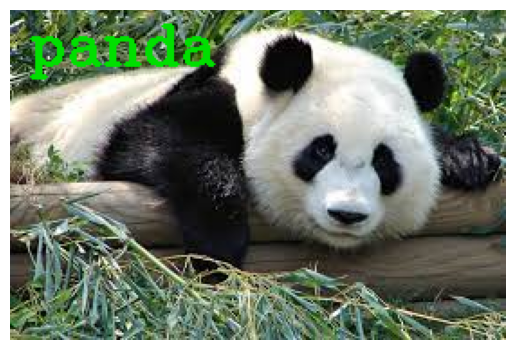

In [20]:
classNames=['cat','dog','panda']
image_path="/content/drive/MyDrive/Resnet/panda.jpeg"
model=load_model("efficient_model.h5")
## preprocess the image
image_input=cv2.imread(image_path)
image_input=cv2.resize(image_input,IMAGE_SIZE,interpolation=cv2.INTER_AREA)
image_input=img_to_array(image_input)
image_input=image_input.astype("float")/255.0
image_input=np.expand_dims(image_input,axis=0)

# predict the image
result=model.predict(image_input)
result=result.argmax(axis=1)[0]
className=classNames[result]
# displa the result on the image
image_input=cv2.imread(image_path)
image_input = cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB)
image_input=cv2.putText(image_input,className,(10,30),cv2.FONT_HERSHEY_COMPLEX,1,(0,223,0),2)
plt.imshow(image_input)
plt.axis('off')
plt.show()